# Neural Network Predictor

## import libraries

In [84]:
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# for data preparation
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# other stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import date
import time

## load training data

In [85]:
df_data_training = pd.read_csv("RESULTS_sobolsampling-2048.csv")
#print(f'{df_data_training}')
df_data_training = df_data_training.drop(columns='Unnamed: 0')
#print(f'{df_data_training}')

colnames = df_data_training.iloc[0:6,0]
#print(f'{colnames}')
cols = []
for i in range(0,5):
    #print(f'{colnames[i]}')
    cols.append(colnames[i])
#print(f'{cols}')

data = []
for i in range(1, df_data_training.shape[1]):
    d = df_data_training.iloc[0:5,i]
    #print(f'd:\n{d}')
    tmp = []
    for j in range(0,5):
        tmp.append(d[j])
    data.append(tmp)    
    #if i == 2:
    #    break

#print(f'{data}')
df_data_training = pd.DataFrame(np.array(data), columns=[cols])
print(f'{df_data_training}')

          SigC      SigH      EpsC      EpsH     density
0     0.329511  0.074231  1.036268  0.062599  891.797000
1     0.066754  0.316262  0.205940  0.119844    0.183657
2     0.193948  0.136800  0.751676  0.037376  664.747000
3     0.230588  0.235899  0.596203  0.100129  682.448000
4     0.242166  0.148891  0.406759  0.087550  688.667000
...        ...       ...       ...       ...         ...
2043  0.242035  0.235637  0.735539  0.137124  708.349000
2044  0.230760  0.148096  1.005841  0.111508  714.162000
2045  0.194069  0.189609  0.357464  0.056020    0.000000
2046  0.066912  0.095994  0.782125  0.108488  651.054000
2047  0.329646  0.259110  0.444702  0.043977  707.088000

[2048 rows x 5 columns]


## load testing data

In [86]:
## data set 1
df_data_testing_1 = pd.read_csv("RESULTS_Testing-1296.csv")
#print(f'{df_data_testing_1}')
#print(f'{df_data_testing_1.columns}')
df_data_testing_1 = df_data_testing_1.drop(columns='Unnamed: 0')
#print(f'{df_data_testing_1}')
#print(f'{df_data_testing_1.columns}')
#print(f'{df_data_testing_1.shape[1]}')

colnames = df_data_testing_1.iloc[0:5,0]
#print(f'{colnames}')
cols = []
for i in range(0,5):
    #print(f'{colnames[i]}')
    cols.append(colnames[i])
#print(f'{cols}')

data = []
for i in range(1, df_data_testing_1.shape[1]):
    d = df_data_testing_1.iloc[0:5,i]
    tmp = []
    for j in range(0,5):
        tmp.append(d[j])
    data.append(tmp)    
    #if i == 2:
    #    break

#print(f'{data}')
df_data_testing_1 = pd.DataFrame(np.array(data), columns=[cols])
print(f'{df_data_testing_1}')

## data set 2
df_data_testing_2 = pd.read_csv("RESULTS_Training-2401.csv")
#print(f'{df_data_testing_2}')
#print(f'{df_data_testing_2.columns}')
df_data_testing_2 = df_data_testing_2.drop(columns='Unnamed: 0')
#print(f'{df_data_testing_2}')
#print(f'{df_data_testing_2.columns}')
#print(f'{df_data_testing_2.shape[1]}')

data = []
for i in range(1, df_data_testing_2.shape[1]):
    d = df_data_testing_2.iloc[0:5,i]
    tmp = []
    for j in range(0,5):
        tmp.append(d[j])
    data.append(tmp)    
    #if i == 2:
    #    break

#print(f'{data}')
df_data_testing_2 = pd.DataFrame(np.array(data), columns=[cols])
print(f'{df_data_testing_2}')

       SigC    SigH    EpsC  EpsH  density
0     0.075  0.0683  0.2465  0.03  640.872
1     0.075  0.0683  0.2465  0.05  634.243
2     0.075  0.0683  0.2465  0.07  626.397
3     0.075  0.0683  0.2465  0.09  631.671
4     0.075  0.0683  0.2465  0.11  639.387
...     ...     ...     ...   ...      ...
1291  0.325  0.2958   1.068  0.05  446.143
1292  0.325  0.2958   1.068  0.07  446.143
1293  0.325  0.2958   1.068  0.09  446.143
1294  0.325  0.2958   1.068  0.11  446.143
1295  0.325  0.2958   1.068  0.13  446.143

[1296 rows x 5 columns]
      SigC    SigH    EpsC  EpsH  density
0     0.05  0.0455  0.1643  0.02  634.421
1     0.05  0.0455  0.1643  0.04  641.987
2     0.05  0.0455  0.1643  0.06  638.865
3     0.05  0.0455  0.1643  0.08   640.72
4     0.05  0.0455  0.1643   0.1  638.745
...    ...     ...     ...   ...      ...
2396  0.35  0.3185  1.1501  0.06  446.143
2397  0.35  0.3185  1.1501  0.08  446.143
2398  0.35  0.3185  1.1501   0.1  446.143
2399  0.35  0.3185  1.1501  0.12  446.1

## prepare training data

In [87]:
df_x_train = df_data_training[['SigC', 'SigH', 'EpsC', 'EpsH']]
x_train = torch.Tensor(df_x_train.to_numpy().astype(float))

df_y_train = df_data_training['density']
y_train = torch.Tensor(df_y_train.to_numpy().astype(float))

train_data = TensorDataset(x_train, y_train)

# setting batch size and dataloader
batch_size = len(x_train)
train_dl = DataLoader(train_data, batch_size, shuffle=True)

## prepare testing data

In [88]:
## data set 1 
df_x_test_1 = df_data_testing_1[['SigC', 'SigH', 'EpsC', 'EpsH']]
x_test_1 = torch.Tensor(df_x_test_1.to_numpy().astype(float))

df_y_test_1 = df_data_testing_1['density']
y_test_1 = torch.Tensor(df_y_test_1.to_numpy().astype(float))

test_data_1 = TensorDataset(x_test_1, y_test_1)

## data set 2
df_x_test_2 = df_data_testing_2[['SigC', 'SigH', 'EpsC', 'EpsH']]
x_test_2 = torch.Tensor(df_x_test_2.to_numpy().astype(float))

df_y_test_2 = df_data_testing_2['density']
y_test_2 = torch.Tensor(df_y_test_2.to_numpy().astype(float))

test_data_2 = TensorDataset(x_test_2, y_test_2)

## a) initialize model and create structure

In [89]:
models = []
model_1 = net = torch.nn.Sequential(
        torch.nn.Linear(4, 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 1),
)# 50 weights
models.append(model_1)

model_2 = net = torch.nn.Sequential(
        torch.nn.Linear(4, 50),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1),
)# 250 weights
models.append(model_2)

model_3 = net = torch.nn.Sequential(
        torch.nn.Linear(4, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
)# 500 weights
models.append(model_3)

model_4 = net = torch.nn.Sequential(
        torch.nn.Linear(4, 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 50),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1),
)# 590 weights
models.append(model_4)

model_5 = net = torch.nn.Sequential(
        torch.nn.Linear(4, 50),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 1),
)# 710 weights
models.append(model_5)

model_6 = net = torch.nn.Sequential(
        torch.nn.Linear(4, 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
)# 1140 weights
models.append(model_6)

model_7 = net = torch.nn.Sequential(
        torch.nn.Linear(4, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 1),
)# 1410 weights
models.append(model_7)

model_8 = net = torch.nn.Sequential(
        torch.nn.Linear(4, 50),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
)# 5300 weights (OVERFIT?!)
models.append(model_8)

model_9 = net = torch.nn.Sequential(
        torch.nn.Linear(4, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 50),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1),
)# 5430 weights (OVERFIT?!)
models.append(model_9)

### optional: load model

In [ ]:
## optional: load states to existing models
model_name = f'tmp_model-4_.pt'
model.load_state_dict(torch.load(model_name))
model.eval()

In [ ]:
## optional: load full models
model_name = f'tmp_model-4_.pt'
model = torch.load(model_name)
model.eval()

### model learning
test the model after every step

In [90]:
num_epochs = 10000

training_stats = []
timings = []

testing_stats_1 = []
testing_stats_2 = []

model_number = 0

for model in models:
    model_number = model_number + 1 
    this_stats_train = []
    this_stats_test_1 = []
    this_stats_test_2 = []
    
    loss_fn = torch.nn.MSELoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr_optuna)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.025)
    this_time_start = time.time()
    

    for epoch in range(num_epochs):
        for step, (xb, yb) in enumerate(train_dl):
            pred_train = model(xb)
            loss_train = loss_fn(pred_train, yb)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        this_stats_train.append([epoch+1, loss_train.item()])
        
        pred_test_1 = model(x_test_1)
        loss_test_1 = loss_fn(pred_test_1, y_test_1)
        this_stats_test_1.append([epoch+1, loss_test_1.item()])
        
        pred_test_2 = model(x_test_2)
        loss_test_2 = loss_fn(pred_test_2, y_test_2)
        this_stats_test_2.append([epoch+1, loss_test_2.item()])
        if epoch%1000 == 0:
            print(f'model_{model_number} - epoch [{epoch+1}/{num_epochs}], loss: {loss_train.item():.4f}')
            
    #print(f'this_stats:\n{this_stats_train}')
    training_stats.append(this_stats_train)
    testing_stats_1.append(this_stats_test_1)
    testing_stats_2.append(this_stats_test_2)
    this_time_end = time.time()
    this_time = this_time_end - this_time_start
    timings.append(this_time)
    #if model_number == 3:
    #    break
#print(f'training_stats:\n{training_stats}')
#print(f'testing_stats_1:\n{testing_stats_1}')
#print(f'testing_stats_2:\n{testing_stats_2}')
#print(f'time:\n{time}')

model_1 - epoch [1/10000], loss: 439441.7500
model_1 - epoch [1001/10000], loss: 18870.8555
model_1 - epoch [2001/10000], loss: 13087.0742
model_1 - epoch [3001/10000], loss: 12291.6592
model_1 - epoch [4001/10000], loss: 12266.4863
model_1 - epoch [5001/10000], loss: 12265.8916
model_1 - epoch [6001/10000], loss: 12265.8887
model_1 - epoch [7001/10000], loss: 12265.8887
model_1 - epoch [8001/10000], loss: 12265.8896
model_1 - epoch [9001/10000], loss: 12265.8906
model_2 - epoch [1/10000], loss: 438988.8125
model_2 - epoch [1001/10000], loss: 12367.9795
model_2 - epoch [2001/10000], loss: 12265.8896
model_2 - epoch [3001/10000], loss: 12265.8896
model_2 - epoch [4001/10000], loss: 12265.8906
model_2 - epoch [5001/10000], loss: 12265.8896
model_2 - epoch [6001/10000], loss: 12265.8896
model_2 - epoch [7001/10000], loss: 12265.8887
model_2 - epoch [8001/10000], loss: 12265.8896
model_2 - epoch [9001/10000], loss: 12265.8896
model_3 - epoch [1/10000], loss: 439169.7188
model_3 - epoch [10

### (optional) quickplot

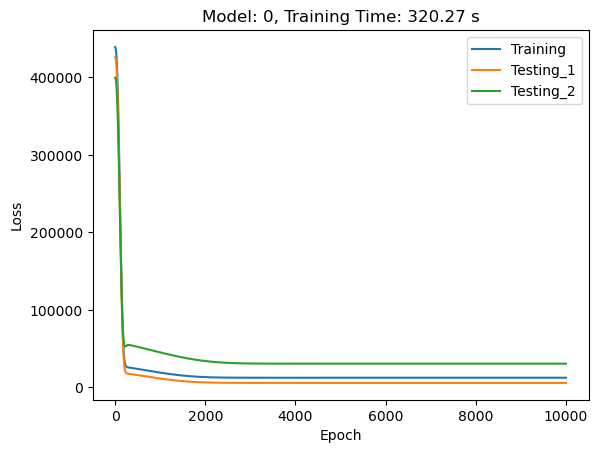

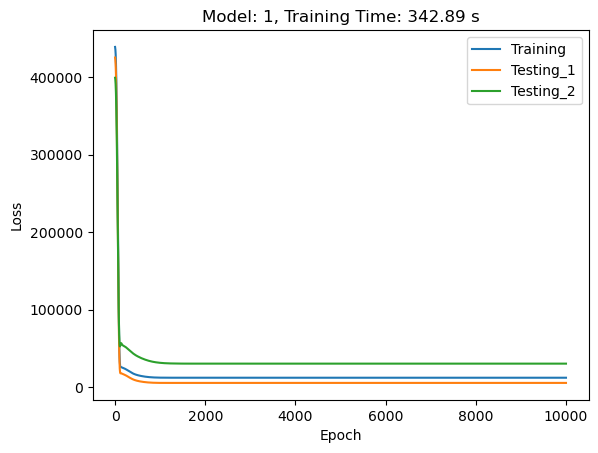

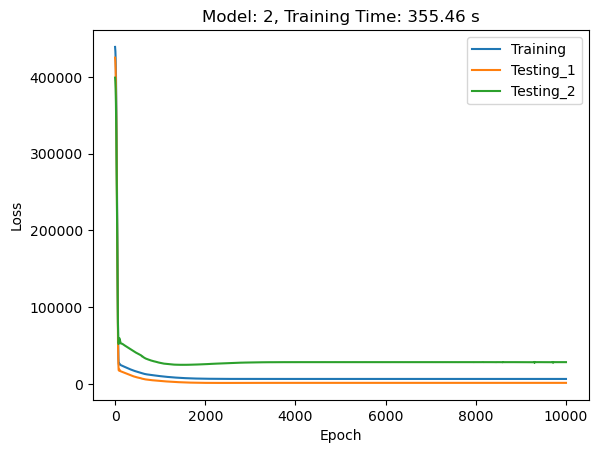

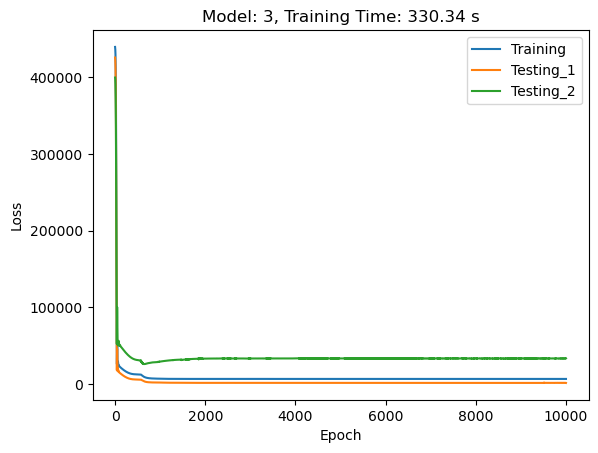

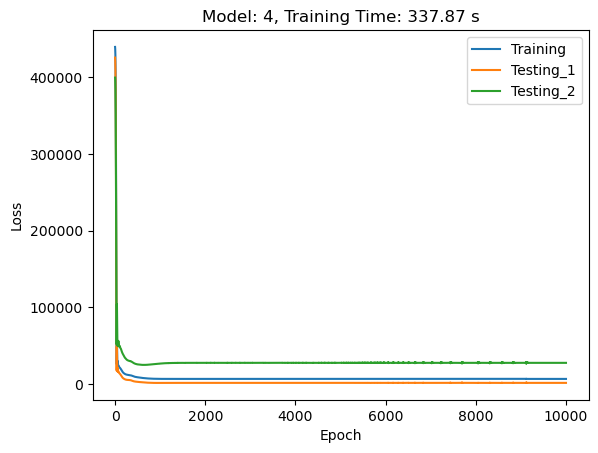

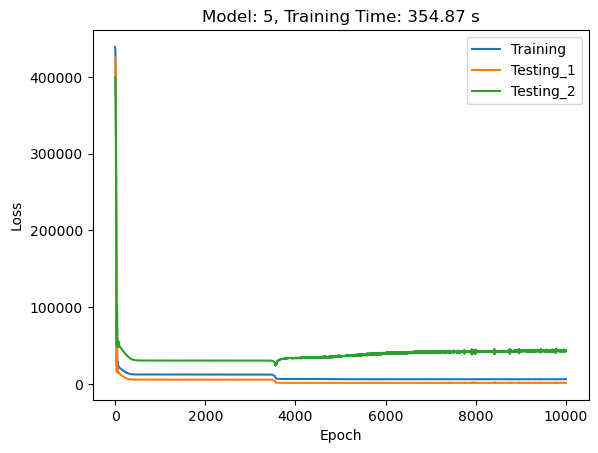

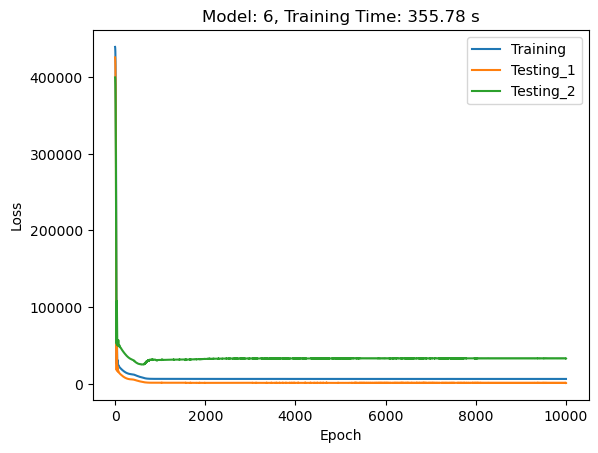

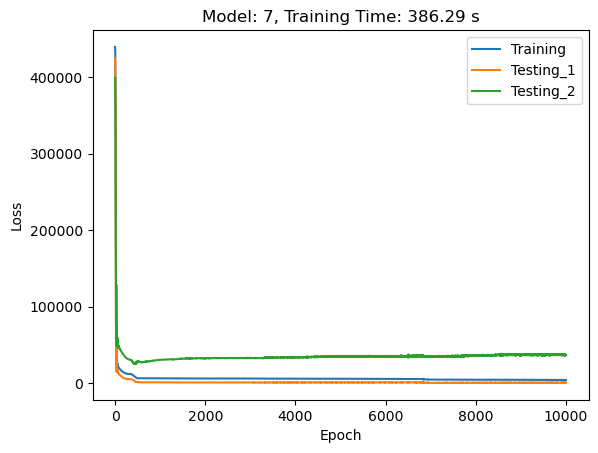

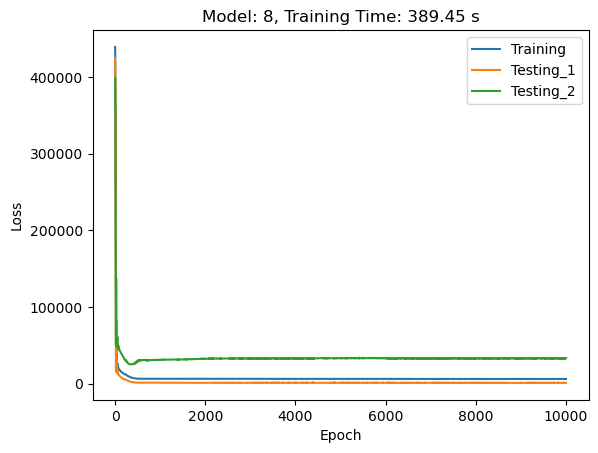

In [91]:
#print(f'len(training_stats) = {len(training_stats)}')
#print(f'len(testing_stats_1) = {len(testing_stats_1)}')
#print(f'len(testing_stats_2) = {len(testing_stats_2)}')

#print(f'len(training_stats[0]) = {len(training_stats[0])}')
#print(f'len(testing_stats_1[0]) = {len(testing_stats_1[0])}')
#print(f'len(testing_stats_2[0]) = {len(testing_stats_2[0])}')

#print(f'len(training_stats[0][0]) = {len(training_stats[0][0])}')
#print(f'len(testing_stats_1[0][0]) = {len(testing_stats_1[0][0])}')
#print(f'len(testing_stats_2[0][0]) = {len(testing_stats_2[0][0])}')

for model_number in range(0, len(training_stats)):
    x = []
    y_train = []
    y_test_1 = []
    y_test_2 = []
    for epoch in range(0, len(training_stats[model_number])):
        #print(training_stats[model_number][epoch])
        x.append(int(epoch))
        y_train.append(float(training_stats[model_number][epoch][1]))
        y_test_1.append(float(testing_stats_1[model_number][epoch][1]))
        y_test_2.append(float(testing_stats_2[model_number][epoch][1]))
    
    plt.figure()
    plt.plot(x, y_train, label='Training')
    plt.plot(x, y_test_1, label='Testing_1')
    plt.plot(x, y_test_2, label='Testing_2')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Model: {model_number}, Training Time: {timings[model_number]:.2f} s')
    #plt.show()
    plt.savefig(f'Epoch-VS-Loss_Training_Model-{model_number}.png')
    #plt.savefig(f'Epoch-VS-Loss_Training_Model-{model_number}.pdf')

    #break
#plt.plot(training_stats[0])
#plt.show()

### save models

In [93]:
#print(f'{learning_stats}')
df_training_stats = pd.DataFrame(training_stats)
#print(f'{df_learning_stats}')
df_training_stats.to_csv(f'{date.today()}_training_stats.csv')

df_testing_stats_1 = pd.DataFrame(testing_stats_1)
df_testing_stats_1.to_csv(f'{date.today()}_testing_stats_1.csv')

df_testing_stats_2 = pd.DataFrame(testing_stats_2)
df_testing_stats_2.to_csv(f'{date.today()}_testing_stats_2.csv')

In [94]:
for i in range(len(models)):
    #print(f'{date.today()} model: {models[i]}')
    ## save model sates
    #torch.save(model.state_dict(), f'tmp_model-5_{loss:.4f}.pt')
    ## save full model
    torch.save(models[i], f'{date.today()}_full_model_{i}.pt')

## test model and calculate RMSE/R^2 Score

In [45]:
#print(f"Total epoch count: {epoch_count}")
#print()

loss_fn = torch.nn.MSELoss()

testing_data_1 = []
testing_data_2 = []

for i in range(len(models)):
    predictions_1 = models[i](x_test_1)
    predictions_2 = models[i](x_test_2)
    #print(f'{predictions_1}')
    #print(f'{predictions_2}')
    
    rmse_1 = torch.sqrt(loss_fn(predictions_1, y_test_1)).item()
    rmse_2 = torch.sqrt(loss_fn(predictions_2, y_test_2)).item()
    predictions_1_np = predictions_1.detach().numpy()
    predictions_2_np = predictions_2.detach().numpy()
    r2_1 = r2_score(y_test_1, predictions_1_np)
    r2_2 = r2_score(y_test_2, predictions_2_np)

    # Print the final predictions
    print(f'RMSE_test_1 = {rmse_1}, R^2_test_1 = {r2_1}')
    print(f'RMSE_test_2 = {rmse_2}, R^2_test_2 = {r2_2}')

    predictions_train = models[i](x_train)
    rmse_train = torch.sqrt(loss_fn(predictions_train, y_train)).item()
    predictions_train_np = predictions_train.detach().numpy()
    r2_train = r2_score(y_train, predictions_train_np)
    print(f'RMSE_train = {rmse_train}, R^2_train = {r2_train}')
    print(f'')
    testing_data_1.append([rmse_1, r2_1])
    testing_data_2.append([rmse_2, r2_2])

df_testing_data_1 = pd.DataFrame(testing_data_1)
df_testing_data_2 = pd.DataFrame(testing_data_2)
#print(f'{df_testing_data_1}')
df_testing_data_1.to_csv(f'{date.today()}_testing_data_1.csv')
df_testing_data_2.to_csv(f'{date.today()}_testing_data_2.csv')

RMSE_test_1 = 74.72630310058594, R^2_test_1 = 0.508755566105449
RMSE_test_2 = 174.48727416992188, R^2_test_2 = 0.304004954795415
RMSE_train = 110.75147247314453, R^2_train = 0.3862548247594566

RMSE_test_1 = 35.00775909423828, R^2_test_1 = 0.8921849715817525
RMSE_test_2 = 178.45660400390625, R^2_test_2 = 0.27197923875189656
RMSE_train = 79.4734115600586, R^2_train = 0.6839667506383253

RMSE_test_1 = 24.49709701538086, R^2_test_1 = 0.9472065663290713
RMSE_test_2 = 178.7932891845703, R^2_test_2 = 0.26922960175791677
RMSE_train = 74.058349609375, R^2_train = 0.7255664961847994

RMSE_test_1 = 35.434364318847656, R^2_test_1 = 0.889541280217684
RMSE_test_2 = 182.34567260742188, R^2_test_2 = 0.23990210960317848
RMSE_train = 80.14440155029297, R^2_train = 0.6786077469317295

RMSE_test_1 = 31.430891036987305, R^2_test_1 = 0.913091134051566
RMSE_test_2 = 168.1421356201172, R^2_test_2 = 0.3537036500477765
RMSE_train = 77.19624328613281, R^2_train = 0.7018180357949719

RMSE_test_1 = 74.72630310058

### plot

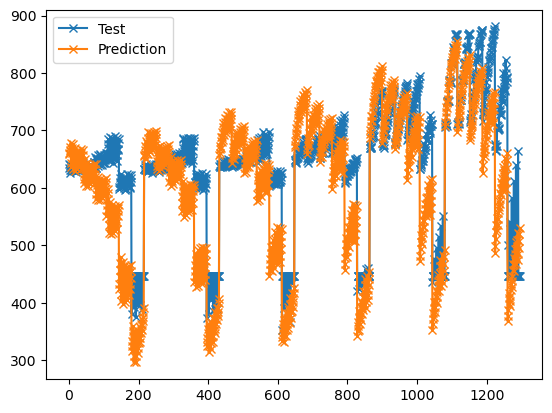

In [22]:
x = range(0,len(predictions))
#print(f'{len(x_test)}')
#print(f'{lenx}')
#print(f'{y_test.detach().numpy().squeeze()}')
#print(f'{predictions.detach().squeeze()}')

plt.figure()
plt.plot(x, y_test.detach().numpy().squeeze(), '-x', label='Test')
plt.plot(x, predictions.detach().squeeze(), '-x', label='Prediction')
plt.legend()
plt.show()

## test 'random' parameters

In [12]:
import random
SigC_lower = 0.0750
SigC_upper = 0.3250

SigH_lower = 0.0683
SigH_upper = 0.2958

EpsC_lower = 0.2465
EpsC_upper = 1.0680

EpsH_lower = 0.0300
EpsH_upper = 0.1300

print(f'SigC\tSigH\tEpsC\tEpsH\t->\tdensity (NN prediction)')
for i in range(0,100):
    rndSigC = float(random.randrange(int(SigC_lower*10000), int(SigC_upper*10000), 1))/10000
    rndSigH = float(random.randrange(int(SigH_lower*10000), int(SigH_upper*10000), 1))/10000
    rndEpsC = float(random.randrange(int(EpsC_lower*10000), int(EpsC_upper*10000), 1))/10000
    rndEpsH = float(random.randrange(int(EpsH_lower*10000), int(EpsH_upper*10000), 1))/10000
    #print(f'{rndSigC}')
    
    rnd_test = np.array([rndSigC, rndSigH, rndEpsC, rndEpsH]).astype(float)
    rnd_test = torch.Tensor(rnd_test)
    #print(f'{rnd_test}')
    rnd_prediction = model(rnd_test)
    #print(f'SigC = {rndSigC}, SigH = {rndSigH}, EpsC = {rndEpsC}, EpsH = {rndEpsH} yield a density prediction of rho = {rnd_prediction}')
    print(f'{rndSigC}\t{rndSigH}\t{rndEpsC}\t{rndEpsH}\t->\t{rnd_prediction[0]}')

SigC	SigH	EpsC	EpsH	->	density (NN prediction)
0.3018	0.0793	0.4249	0.1174	->	722.4707641601562
0.1653	0.2939	0.9784	0.093	->	451.5457763671875
0.1414	0.1166	0.8632	0.1081	->	647.724609375
0.2865	0.1593	0.2509	0.0348	->	686.1533203125
0.2695	0.0936	0.4974	0.1252	->	698.26904296875
0.115	0.1143	0.5667	0.081	->	640.5513916015625
0.3195	0.2804	0.3362	0.1151	->	545.4305419921875
0.1361	0.0752	0.7665	0.0814	->	637.292236328125
0.1913	0.26	0.9549	0.0908	->	595.6490478515625
0.2614	0.1874	0.5269	0.044	->	698.7801513671875
0.2443	0.2545	0.5689	0.0963	->	628.8834228515625
0.2783	0.1332	0.8191	0.0359	->	752.617431640625
0.0798	0.1969	0.5363	0.0708	->	658.5140380859375
0.1792	0.2787	0.3275	0.0422	->	504.3411865234375
0.1725	0.117	1.0597	0.0647	->	647.5997924804688
0.1389	0.2476	0.5901	0.0932	->	623.24560546875
0.0904	0.2548	0.7285	0.0381	->	580.9443359375
0.2218	0.2913	0.6087	0.1292	->	469.9795227050781
0.1931	0.0863	0.8655	0.0546	->	646.4988403320312
0.1084	0.1422	0.3855	0.119	->	650.39813232421